In [44]:
import opendatasets as od
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

import numpy as np

import scipy
from scipy.stats import gaussian_kde

In [45]:
bank_df= pd.read_csv("bank-customer-churn/Customer-Churn-Records.csv")
bank_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [46]:
bank_df.columns = [i.lower().replace(' ','_') for i in bank_df.columns]
print("Tiene algun elemento vacio? : {}".format(bank_df.isnull().any().any()))
bank_df = bank_df.drop(columns = ['rownumber','customerid',"surname"])

Tiene algun elemento vacio? : False


In [56]:
#Changes made
bank_df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,complain,satisfaction_score,card_type,point_earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## EDA

Idea principal:
Buscar 2 columnas DISTINTAS A EXITED para clusterizar
Luego probar si esos patrones de clasificacion tienen mayor cantidad de exited.

Colunas encontradas interesantes: 

- CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- Geography—a customer’s location can affect their decision to leave the bank
Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
IsActiveMember—active customers are less likely to leave the bank.
EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

In [47]:
# Separamos las columnas para graficarlas y hacer un EDA
df = bank_df

col_cat = df.select_dtypes('object')
col_cat = col_cat[['geography','gender','card_type']]
num_col = df.select_dtypes(['int64','float64'])   

### Contadores de colunas categóricas


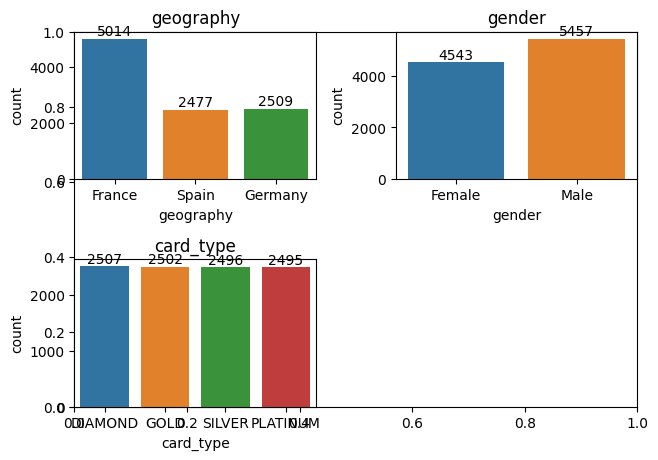

In [63]:
fig, ax = plt.subplots(figsize = (7,5))

for i,j in enumerate(col_cat):
    ax = fig.add_subplot(2,2,i+1)
    ax = sns.countplot(bank_df, x = j)
    ax.bar_label(ax.containers[0], label_type='edge')
    ax.set_title(j)

plt.tight_layout()          
plt.show()

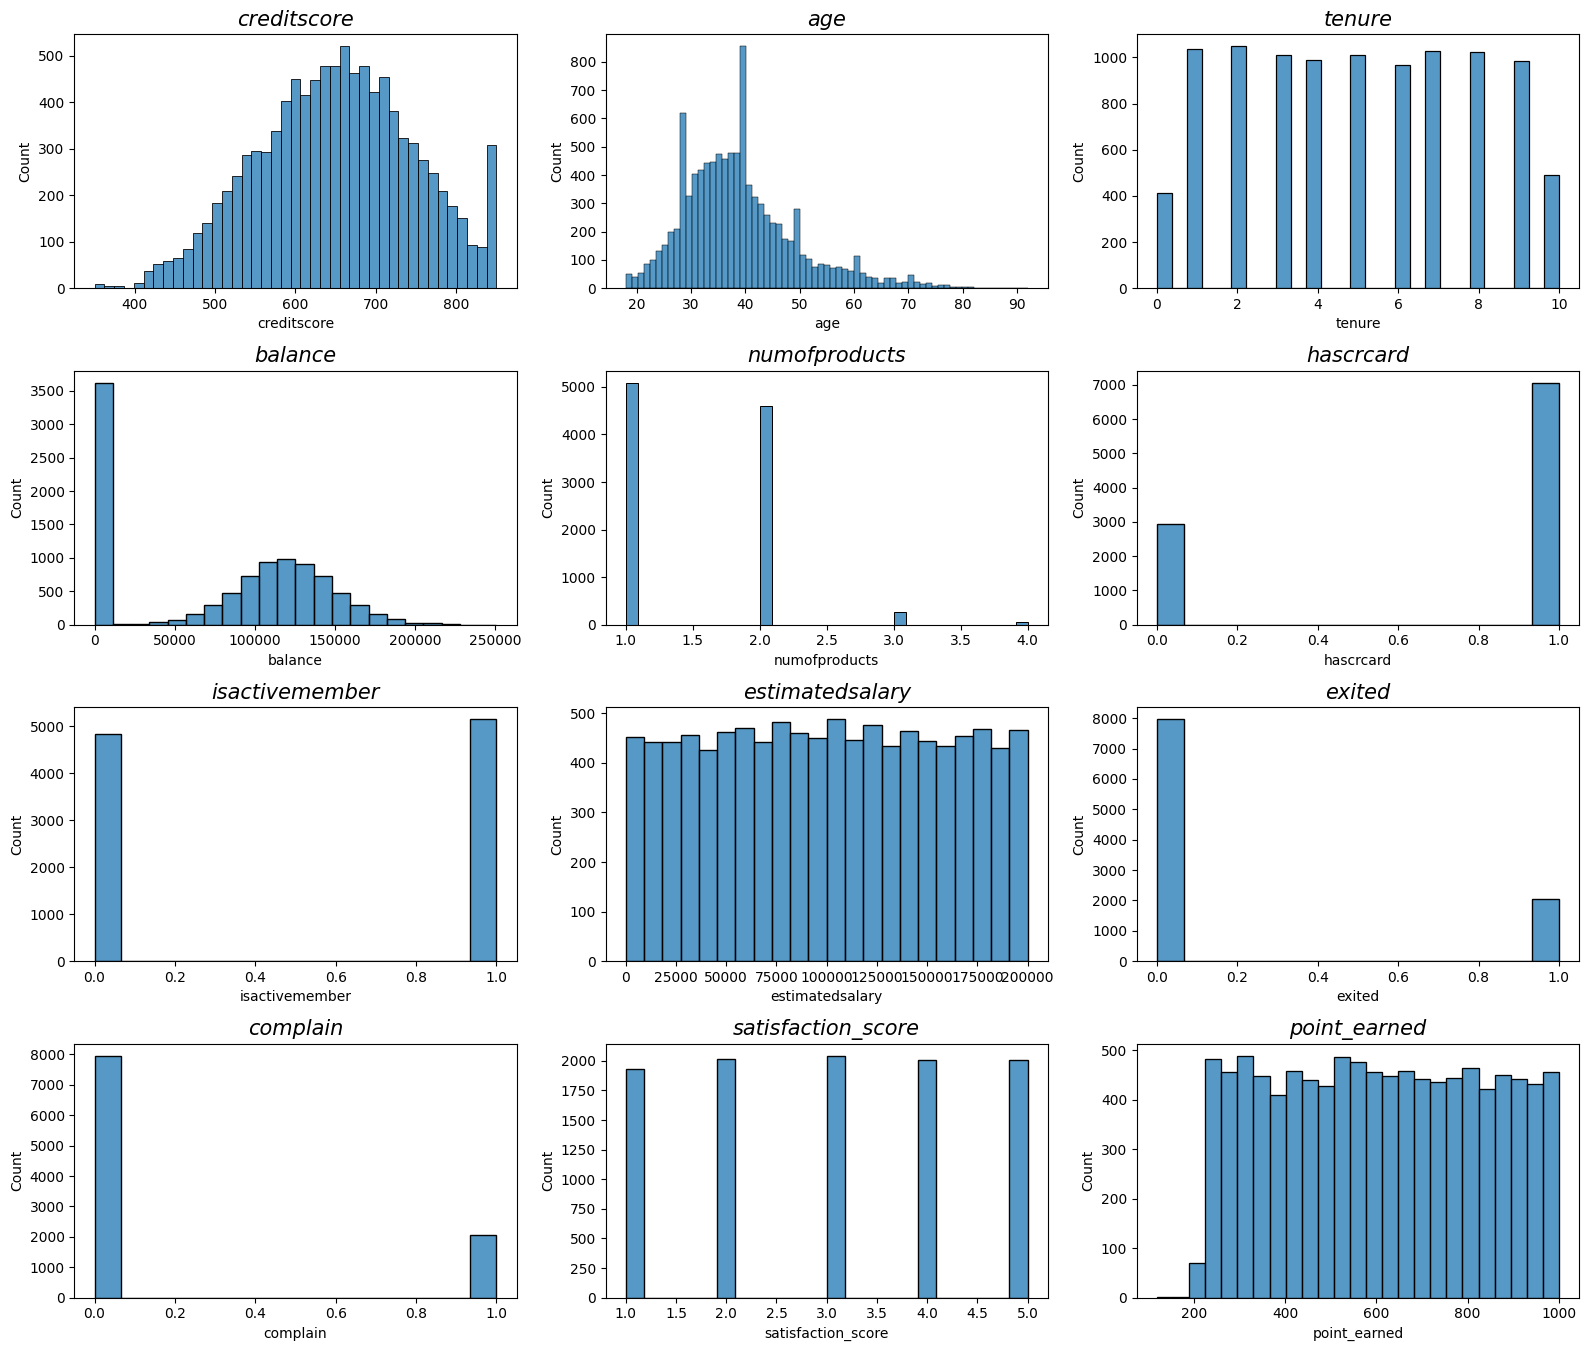

In [49]:
# Columnas numericas
fig = plt.figure(figsize = (16,30))

for i,j in enumerate(num_col):
    ax = fig.add_subplot(9,3,i+1)
    ax = sns.histplot(bank_df, x = j)
    ax.set_title(j, fontsize = 15, style = "italic")

plt.tight_layout()
plt.show()

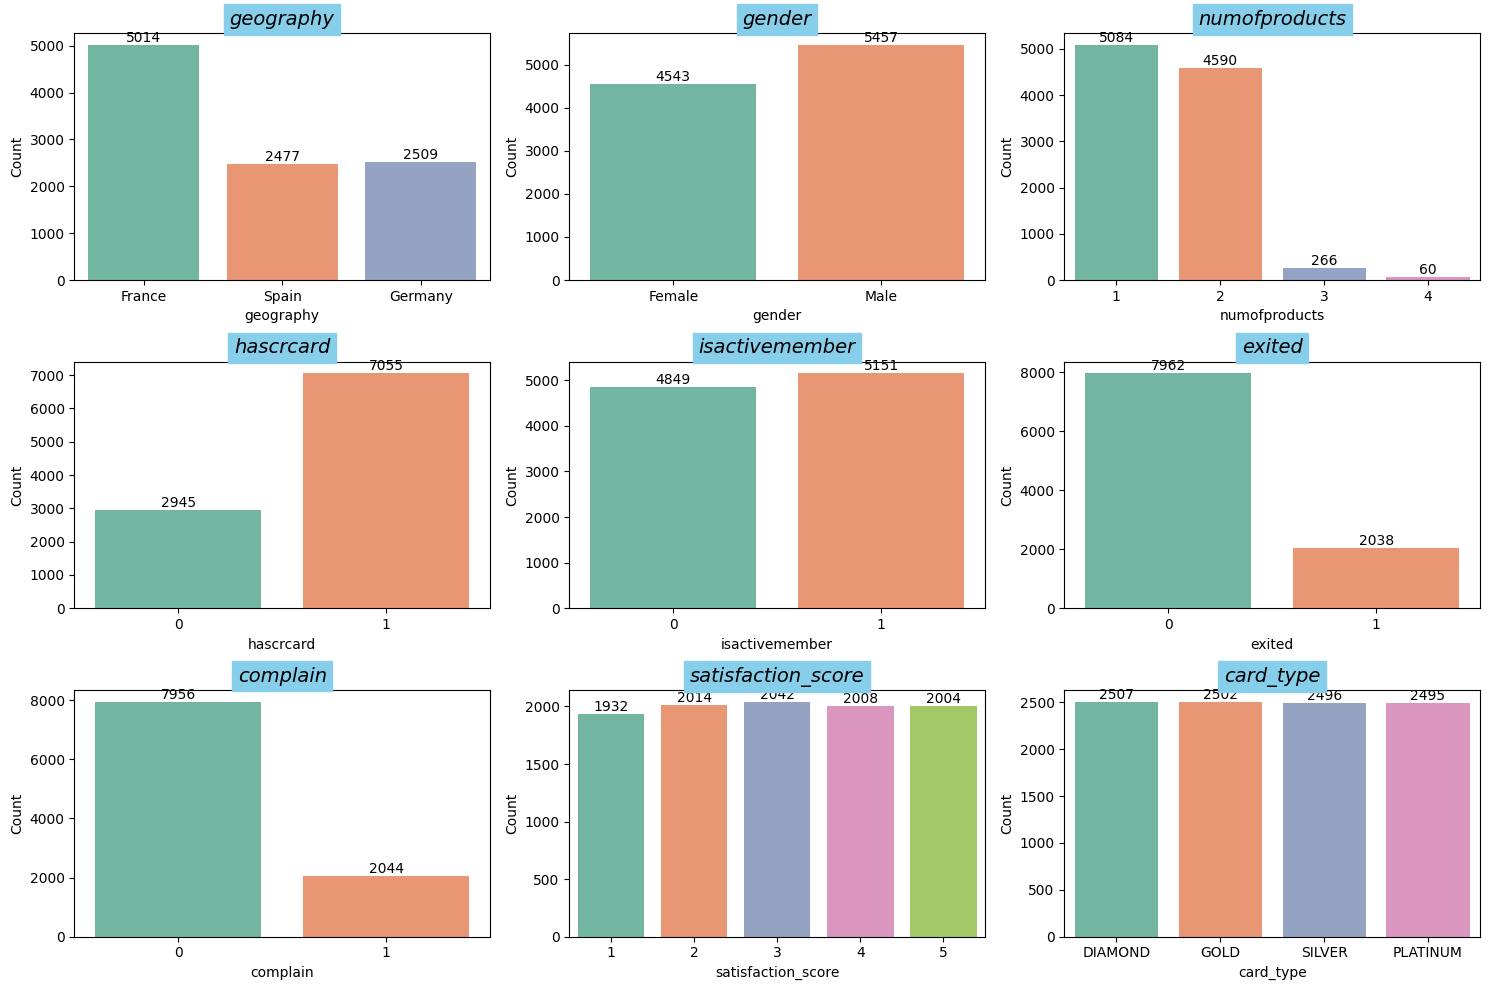

In [50]:
# Take a quick look at categorical features and feature with discrete values
feature = ['geography', 'gender', 'numofproducts', 'hascrcard', 'isactivemember', 'exited', 'complain', 'satisfaction_score', 'card_type']

fig = plt.figure(figsize = (15,10))

for i,j in enumerate(feature):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.countplot(bank_df , x = j , palette = sns.color_palette("Set2"))
    ax.set_title(j , fontsize = 14 , style = 'italic', backgroundcolor = 'skyblue')
    ax.set_ylabel('Count')
    ax.bar_label(ax.containers[0], label_type='edge')
plt.tight_layout()    
plt.show()    

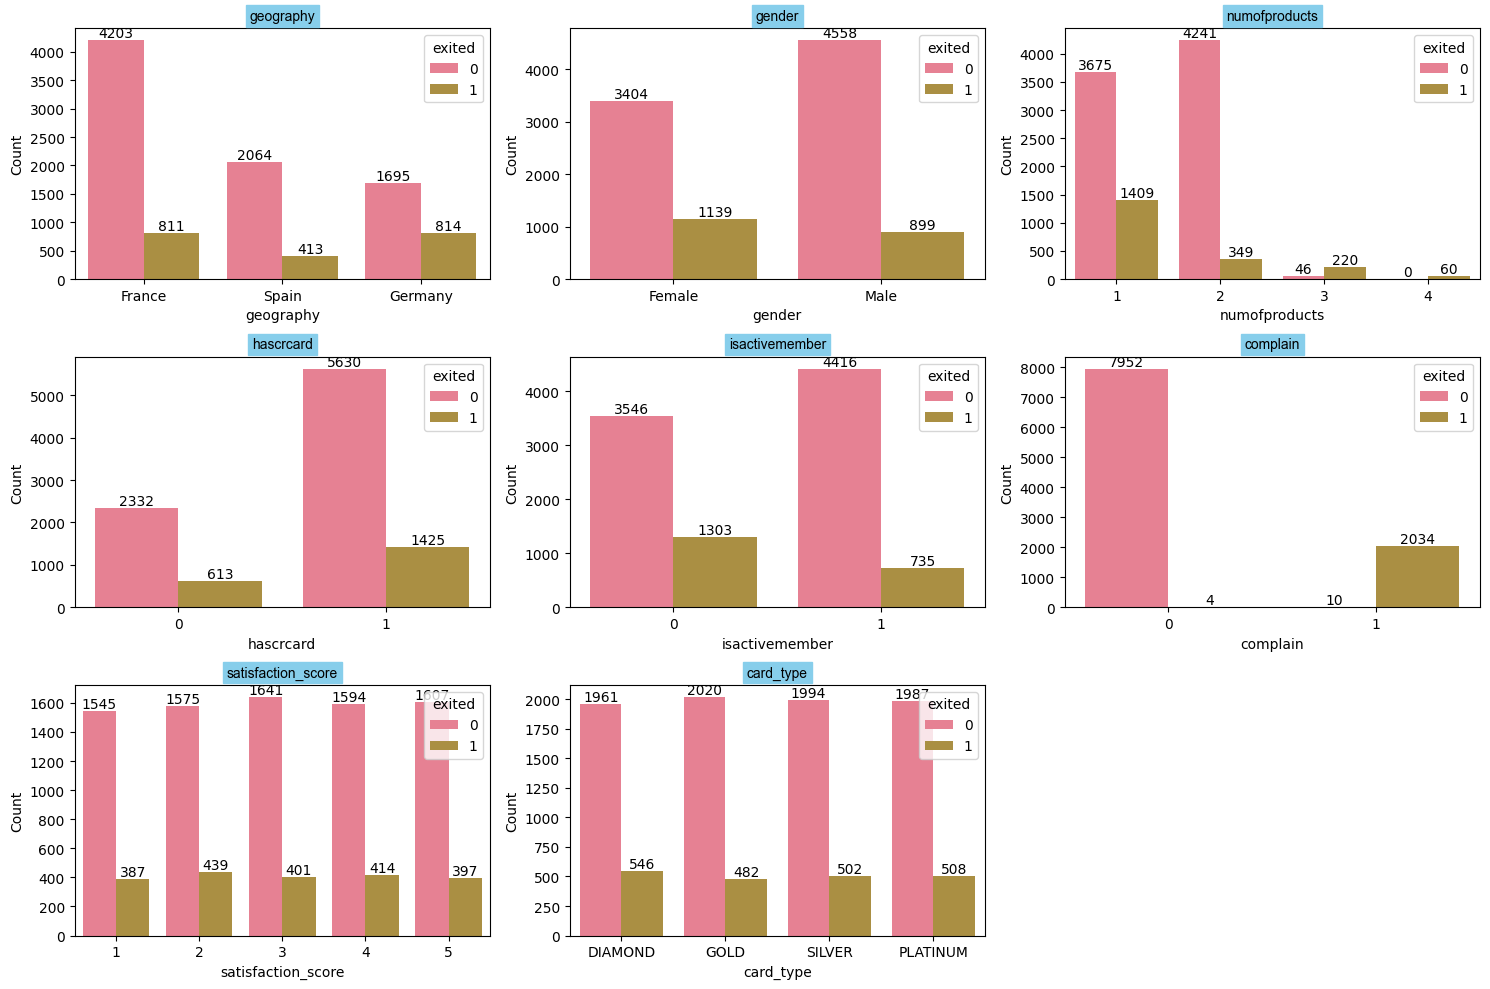

In [51]:
# Take a quick look at some features by churn
# 0 means not change and 1 means change
feature = ['geography', 'gender', 'numofproducts', 'hascrcard', 'isactivemember', 'complain', 'satisfaction_score', 'card_type']

fig = plt.figure(figsize = (15,10))

for i,j in enumerate(feature):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.countplot(bank_df , x = j , hue = 'exited' , palette = sns.color_palette('husl') )
    ax.set_title(j , fontsize = 15 , style = 'italic' , backgroundcolor = 'skyblue', font = 'Arial')
    ax.set_ylabel('Count')
    ax.bar_label(ax.containers[0],label_type='edge')
    ax.bar_label(ax.containers[1],label_type='edge')
plt.tight_layout()    
plt.show()    

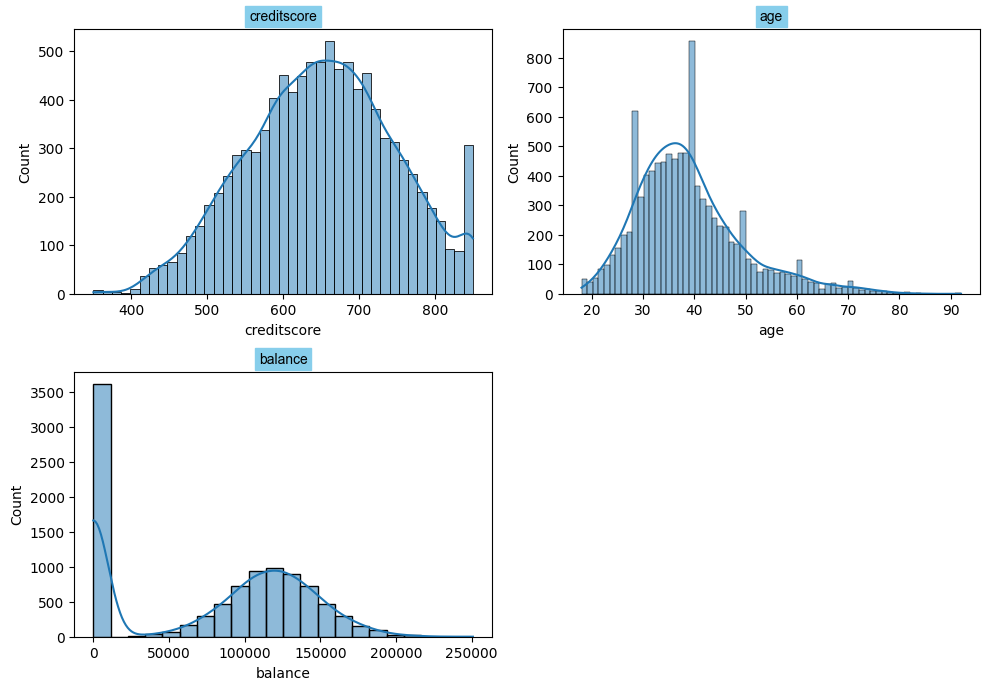

In [52]:
# Take a look at continous features
feat = ['creditscore','age','balance']

fig = plt.figure(figsize = (10,10))

for i,j in enumerate(feat):
    ax = fig.add_subplot(3,2,i+1)
    ax = sns.histplot(bank_df, x = j ,kde = True)
    ax.set_title(j , fontsize = 15 , style = 'italic' , backgroundcolor = 'skyblue', font = 'Arial')
    ax.set_ylabel('Count')
    
plt.tight_layout()      
plt.show() 

In [64]:
lista=bank_df.columns.tolist()
fig, ax = plt.figure(figsize = (18,19))

for i,horizontal in enumerate(lista):
    for j,vertical in enumerate(lista):
        ax = fig.add_subplot(3,2,j+1)
        ax = sns.scatterplot(bank_df, x=horizontal, y = vertical, hue="exited")
        ax.set_title(j , fontsize = 15 , style = 'italic' , backgroundcolor = 'skyblue', font = 'Arial')
        ax.set_ylabel()

TypeError: cannot unpack non-iterable Figure object

<Figure size 18000x19000 with 0 Axes>

### Balance VS age

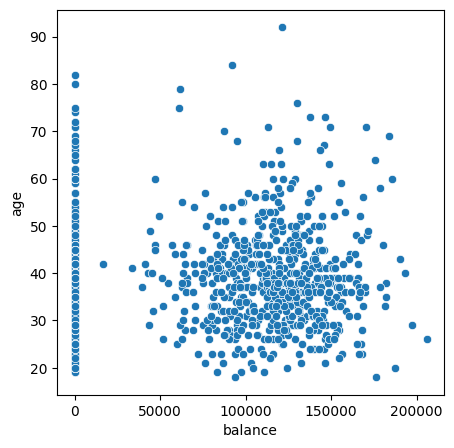

In [54]:
df = bank_df.sample(1000)

fig = plt.figure(figsize = (5,5))
ax = sns.scatterplot(df, x="balance", y = "age")


# No hay gente de alemania con balance 0?

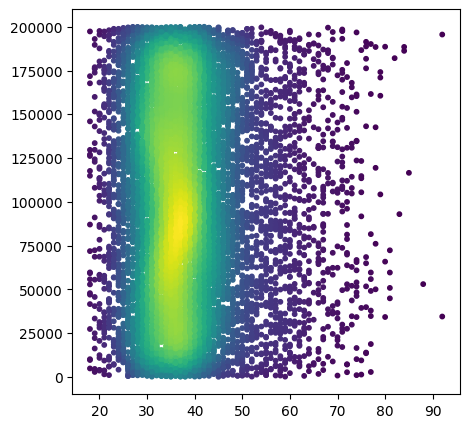

In [55]:


x = bank_df["age"]
y = bank_df["estimatedsalary"]



# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(x, y, c=z, s=10)
plt.show()